Christina sent me this notebook on 1/16/2023.

It contains code to help with PSF fitting for scenes and uses several functions from pandors-psf.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
from copy import deepcopy
from functools import lru_cache

import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates import Distance, SkyCoord
from astropy.time import Time
from astropy.wcs import WCS
from astroquery.gaia import Gaia
from scipy import sparse
from tqdm import tqdm

In [3]:
# We'll use this for apertures
def gaussian_2d(x, y, mu_x, mu_y, sigma_x=2, sigma_y=2):
    """
    Compute the value of a 2D Gaussian function.

    Parameters:
    x (float): x-coordinate.
    y (float): y-coordinate.
    mu_x (float): Mean of the Gaussian in the x-direction.
    mu_y (float): Mean of the Gaussian in the y-direction.
    sigma_x (float): Standard deviation of the Gaussian in the x-direction.
    sigma_y (float): Standard deviation of the Gaussian in the y-direction.

    Returns:
    float: Value of the 2D Gaussian function at (x, y).
    """
    part1 = 1 / (2 * np.pi * sigma_x * sigma_y)
    part2 = np.exp(
        -((x - mu_x) ** 2 / (2 * sigma_x**2) + (y - mu_y) ** 2 / (2 * sigma_y**2))
    )
    return part1 * part2

def dgaussian_2d(x, y, mu_x, mu_y, sigma_x=2, sigma_y=2):
    """
    Compute the value of a 2D Gaussian function. (This returns the amplitude you need to multiply by a Gaussian to get the actual gradient.)

    Parameters:
    x (float): x-coordinate.
    y (float): y-coordinate.
    mu_x (float): Mean of the Gaussian in the x-direction.
    mu_y (float): Mean of the Gaussian in the y-direction.
    sigma_x (float): Standard deviation of the Gaussian in the x-direction.
    sigma_y (float): Standard deviation of the Gaussian in the y-direction.

    """
    
    dG_x = -(x - mu_x)/sigma_x**2
    dG_y = -(y - mu_y)/sigma_y**2
    return dG_x, dG_y

class SparseWarp3D(sparse.coo_matrix):
    """Special class for working with stacks of sparse 3D images"""

    def __init__(self, data, row, col, imshape):
        if not np.all([row.ndim == 3, col.ndim == 3, data.ndim == 3]):
            raise ValueError("Pass a 3D array (nrow, ncol, nvecs)")
        self.nvecs = data.shape[-1]
        if not np.all(
            [
                row.shape[-1] == self.nvecs,
                col.shape[-1] == self.nvecs,
            ]
        ):
            raise ValueError("Must have the same 3rd dimension (nvecs).")
        self.subrow = row.astype(int)
        self.subcol = col.astype(int)
        self.subdepth = (
            np.arange(row.shape[-1], dtype=int)[None, None, :]
            * np.ones(row.shape, dtype=int)[:, :, None]
        )
        self.subdata = data
        self._kz = self.subdata != 0

        self.imshape = imshape
        self.subshape = row.shape
        self.cooshape = (np.prod([*self.imshape[:2]]), self.nvecs)
        self.coord = (0, 0)
        super().__init__(self.cooshape)
        index0 = (np.vstack(self.subrow)) * self.imshape[1] + (np.vstack(self.subcol))
        index1 = np.vstack(self.subdepth).ravel()
        self._index_no_offset = np.vstack([index0.ravel(), index1.ravel()])
        self._submask_no_offset = np.vstack(self._get_submask(offset=(0, 0))).ravel()
        self._subrow_v = deepcopy(np.vstack(self.subrow).ravel())
        self._subcol_v = deepcopy(np.vstack(self.subcol).ravel())
        self._subdata_v = deepcopy(np.vstack(deepcopy(self.subdata)).ravel())
        self._index1 = np.vstack(self.subdepth).ravel()

        self._set_data()

    def __add__(self, other):
        if isinstance(other, SparseWarp3D):
            data = deepcopy(self.subdata + other.subdata)
            if (
                (self.subcol != other.subcol)
                | (self.subrow != other.subrow)
                | (self.imshape != other.imshape)
                | (self.subshape != other.subshape)
            ):
                raise ValueError("Must have same base indicies.")
            return SparseWarp3D(
                data=data, row=self.subrow, col=self.subcol, imshape=self.imshape
            )
        else:
            return super(sparse.coo_matrix, self).__add__(other)

    def tocoo(self):
        return sparse.coo_matrix((self.data, (self.row, self.col)), shape=self.cooshape)

    def index(self, offset=(0, 0)):
        """Get the 2D positions of the data"""
        if offset == (0, 0):
            return self._index_no_offset
        index0 = (self._subrow_v + offset[0]) * self.imshape[1] + (
            self._subcol_v + offset[1]
        )
        return index0, self._index1

    def _get_submask(self, offset=(0, 0)):
        # find where the data is within the array bounds
        kr = ((self.subrow + offset[0]) < self.imshape[0]) & (
            (self.subrow + offset[0]) >= 0
        )
        kc = ((self.subcol + offset[1]) < self.imshape[1]) & (
            (self.subcol + offset[1]) >= 0
        )
        return kr & kc & self._kz

    def _set_data(self, offset=(0, 0)):
        if offset == (0, 0):
            index0, index1 = self.index((0, 0))
            self.row, self.col = (
                index0[self._submask_no_offset],
                index1[self._submask_no_offset],
            )
            self.data = self._subdata_v[self._submask_no_offset]
        else:
            # find where the data is within the array bounds
            k = self._get_submask(offset=offset)
            k = np.vstack(k).ravel()
            new_row, new_col = self.index(offset=offset)
            self.row, self.col = new_row[k], new_col[k]
            self.data = self._subdata_v[k]
        self.coord = offset

    def __repr__(self):
        return (
            f"<{(*self.imshape, self.nvecs)} SparseWarp3D array of type {self.dtype}>"
        )

    def dot(self, other):
        if other.ndim == 1:
            other = other[:, None]
        nt = other.shape[1]
        return super().dot(other).reshape((*self.imshape, nt)).transpose([2, 0, 1])

    def reset(self):
        """Reset any translation back to the original data"""
        self._set_data(offset=(0, 0))
        self.coord = (0, 0)
        return

    def clear(self):
        """Clear data in the array"""
        self.data = np.asarray([])
        self.row = np.asarray([])
        self.col = np.asarray([])
        self.coord = (0, 0)
        return

    def translate(self, position):
        """Translate the data in the array by `position` in (row, column)"""
        self.reset()
        # If translating to (0, 0), do nothing
        if position == (0, 0):
            return
        self.clear()
        self._set_data(position)
        return

In [4]:
@lru_cache()
def _query_gaia(query_str):
    job = Gaia.launch_job_async(query_str, verbose=False)
    tbl = job.get_results()
    return deepcopy(tbl)

In [5]:
def get_sky_catalog(
    ra=210.8023,
    dec=54.349,
    radius=0.155,
    grpmagnitude_range=(-3, 20),
    epoch=Time.now(),
    limit=None,
    gaia_keys=[
        "source_id",
        "ra",
        "dec",
        "parallax",
        "pmra",
        "pmdec",
        "radial_velocity",
        "ruwe",
        "phot_rp_mean_flux",
        "teff_gspphot",
        "logg_gspphot",
    ],
):
    """Gets a catalog of coordinates on the sky based on an input ra, dec and radius"""

    query_str = f"""
    SELECT {f'TOP {limit} ' if limit is not None else ''}* FROM (
        SELECT gaia.{', gaia.'.join(gaia_keys)}, dr2.teff_val AS dr2_teff_val,
        dr2.rv_template_logg AS dr2_logg, tmass.j_m, tmass.j_msigcom, tmass.ph_qual, DISTANCE(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        POINT(gaia.ra, gaia.dec)) AS ang_sep,
        EPOCH_PROP_POS(gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec,
        gaia.radial_velocity, gaia.ref_epoch, 2000) AS propagated_position_vector
        FROM gaiadr3.gaia_source AS gaia
        JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
        JOIN gaiadr3.dr2_neighbourhood AS xmatch2 ON gaia.source_id = xmatch2.dr3_source_id
        JOIN gaiadr2.gaia_source AS dr2 ON xmatch2.dr2_source_id = dr2.source_id
        JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
        JOIN gaiadr1.tmass_original_valid AS tmass ON
        xjoin.original_psc_source_id = tmass.designation
        WHERE 1 = CONTAINS(
        POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
        CIRCLE(gaia.ra, gaia.dec, {(u.Quantity(radius, u.deg) + 50*u.arcsecond).value}))
        AND gaia.parallax IS NOT NULL
        AND gaia.phot_rp_mean_mag > {grpmagnitude_range[0]}
        AND gaia.phot_rp_mean_mag < {grpmagnitude_range[1]}) AS subquery
    WHERE 1 = CONTAINS(
    POINT({u.Quantity(ra, u.deg).value}, {u.Quantity(dec, u.deg).value}),
    CIRCLE(COORD1(subquery.propagated_position_vector), COORD2(subquery.propagated_position_vector), {u.Quantity(radius, u.deg).value}))
    ORDER BY ang_sep ASC
    """
    tbl = _query_gaia(query_str)
    if len(tbl) == 0:
        raise ValueError("Could not find matches.")

    tbl = tbl.to_pandas()
    k = (~np.isfinite(tbl["parallax"])) | (tbl["parallax"] < 0)
    tbl.loc[k, "parallax"] = 0
    k = ~np.isfinite(tbl["logg_gspphot"])
    tbl.loc[k, "logg_gspphot"] = tbl["dr2_logg"][k]
    k = ~np.isfinite(tbl["teff_gspphot"])
    tbl.loc[k, "teff_gspphot"] = tbl["dr2_teff_val"][k]
    k = ~np.isfinite(tbl["ruwe"])
    tbl.loc[k, "ruwe"] = 99
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c = SkyCoord(
            ra=tbl["ra"] * u.deg,
            dec=tbl["dec"] * u.deg,
            pm_ra_cosdec=np.nan_to_num(tbl["pmra"]) * u.mas / u.year,
            pm_dec=np.nan_to_num(tbl["pmdec"]) * u.mas / u.year,
            obstime=Time.strptime("2016", "%Y"),
            distance=Distance(
                parallax=np.asarray(tbl["parallax"]) * u.mas, allow_negative=True
            ),
            radial_velocity=np.nan_to_num(tbl["radial_velocity"]) * u.km / u.s,
        ).apply_space_motion(epoch)
        tbl["RA_EPOCH"] = c.ra.deg
        tbl["DEC_EPOCH"] = c.dec.deg
    return tbl

In [6]:
from astropy.io import fits

In [7]:
# open up a TESS ffi
hdulist = fits.open(
    # "/Users/chedges/Downloads/ffis/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
    "./data/tess2022363171841-s0060-1-3-0249-s_ffic.fits"
)
wcs = WCS(hdulist[1].header)

# take a cut out
R, C = np.mgrid[1500:1700, 1501:1700]
image_shape = R.shape
R0, C0 = R[:, 0].mean(), C[0].mean()
wR, wC = R - R0, C - C0
data = hdulist[1].data[1500:1700, 1501:1700]
err = hdulist[2].data[1500:1700, 1501:1700]

# set up WCS
c = wcs.pixel_to_world(R0, C0)
ra0, dec0 = c.ra.deg, c.dec.deg
l = np.asarray([[0, 0], [0, -1], [-1, 0], [-1, -1]]).T
cs = wcs.pixel_to_world(R[l[0], l[1]], C[l[0], l[1]])
radius = np.max(c.separation(cs).deg)
df = get_sky_catalog(
    ra0,
    dec0,
    radius=radius,
    grpmagnitude_range=(-3, 16),
    epoch=Time(hdulist[0].header["DATE-OBS"]),
)
df[["X0", "Y0"]] = np.round(np.asarray(
    wcs.world_to_pixel(SkyCoord(df["RA_EPOCH"], df["DEC_EPOCH"], unit="deg"))
).T, 2)

k = (
    (df.X0 > R[0, 0] - 3)
    & (df.X0 < R[-1, 0] + 3)
    & (df.Y0 > C[0, 0] - 3)
    & (df.Y0 < C[0, -1] + 3)
)
df = df[k]


k = data.ravel() < np.percentile(data, 20)
polyorder = 2
poly = np.vstack(
    [
        wR.ravel() ** idx * wC.ravel() ** jdx
        for idx in range(polyorder + 1)
        for jdx in range(polyorder + 1)
    ]
).T
bkg_model = poly.dot(
    np.linalg.solve(poly[k].T.dot(poly[k]), poly[k].T.dot(data.ravel()[k]))
).reshape(data.shape)
data -= bkg_model

Set MJD-END to 59942.729154 from DATE-END'. [astropy.wcs.wcs]


INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
df = df.sort_values('phot_rp_mean_flux')
df = df.drop_duplicates(['X0', 'Y0'], keep='first')
df = df.reset_index(drop=True)

In [13]:
print(len(df))
df[:5]

3143


,dr2_teff_val,propagated_position_vector,dec,ruwe,parallax,dr2_logg,j_msigcom,ra,ang_sep,phot_rp_mean_flux,...,pmra,pmdec,j_m,source_id,logg_gspphot,teff_gspphot,RA_EPOCH,DEC_EPOCH,X0,Y0
0,5685.985352,"(1.79064830511656 , 0.683440042445068)",39.158232,1.019163,0.222061,NaN,0.055,102.596572,0.651816,3166.281233,...,-3.176439,0.380949,15.393,944517085677482368,4.6640,5538.613281,102.596564,39.158232,1500.40,1547.89
1,4683.419922,"(1.79118882359039 , 0.687791554848666)",39.407513,0.974321,0.974412,NaN,0.044,102.627541,0.568928,3166.735423,...,-3.279753,-9.107122,15.074,944524266862657792,4.6271,4413.380371,102.627533,39.407495,1502.43,1590.75
2,5973.602539,"(1.80640005660627 , 0.692327652867298)",39.667439,1.018049,0.334939,NaN,0.048,103.499099,0.261636,3167.202768,...,-0.142528,-3.080515,15.467,950544196104206720,4.6313,5688.393555,103.499098,39.667433,1614.94,1642.06
3,5760.000000,"(1.8139859007422 , 0.689140117004876)",39.484813,0.972181,0.258969,NaN,0.049,103.933732,0.443966,3168.295665,...,-0.681731,-1.538065,15.437,950342504439512064,4.6115,5614.627930,103.933731,39.484810,1674.03,1614.78
4,5705.800293,"(1.80298677691424 , 0.691554543624464)",39.623147,1.096550,0.272889,NaN,0.067,103.303539,0.200950,3168.548093,...,0.990688,-2.223590,15.363,950546017170349184,4.6745,5553.535156,103.303541,39.623142,1589.67,1632.86


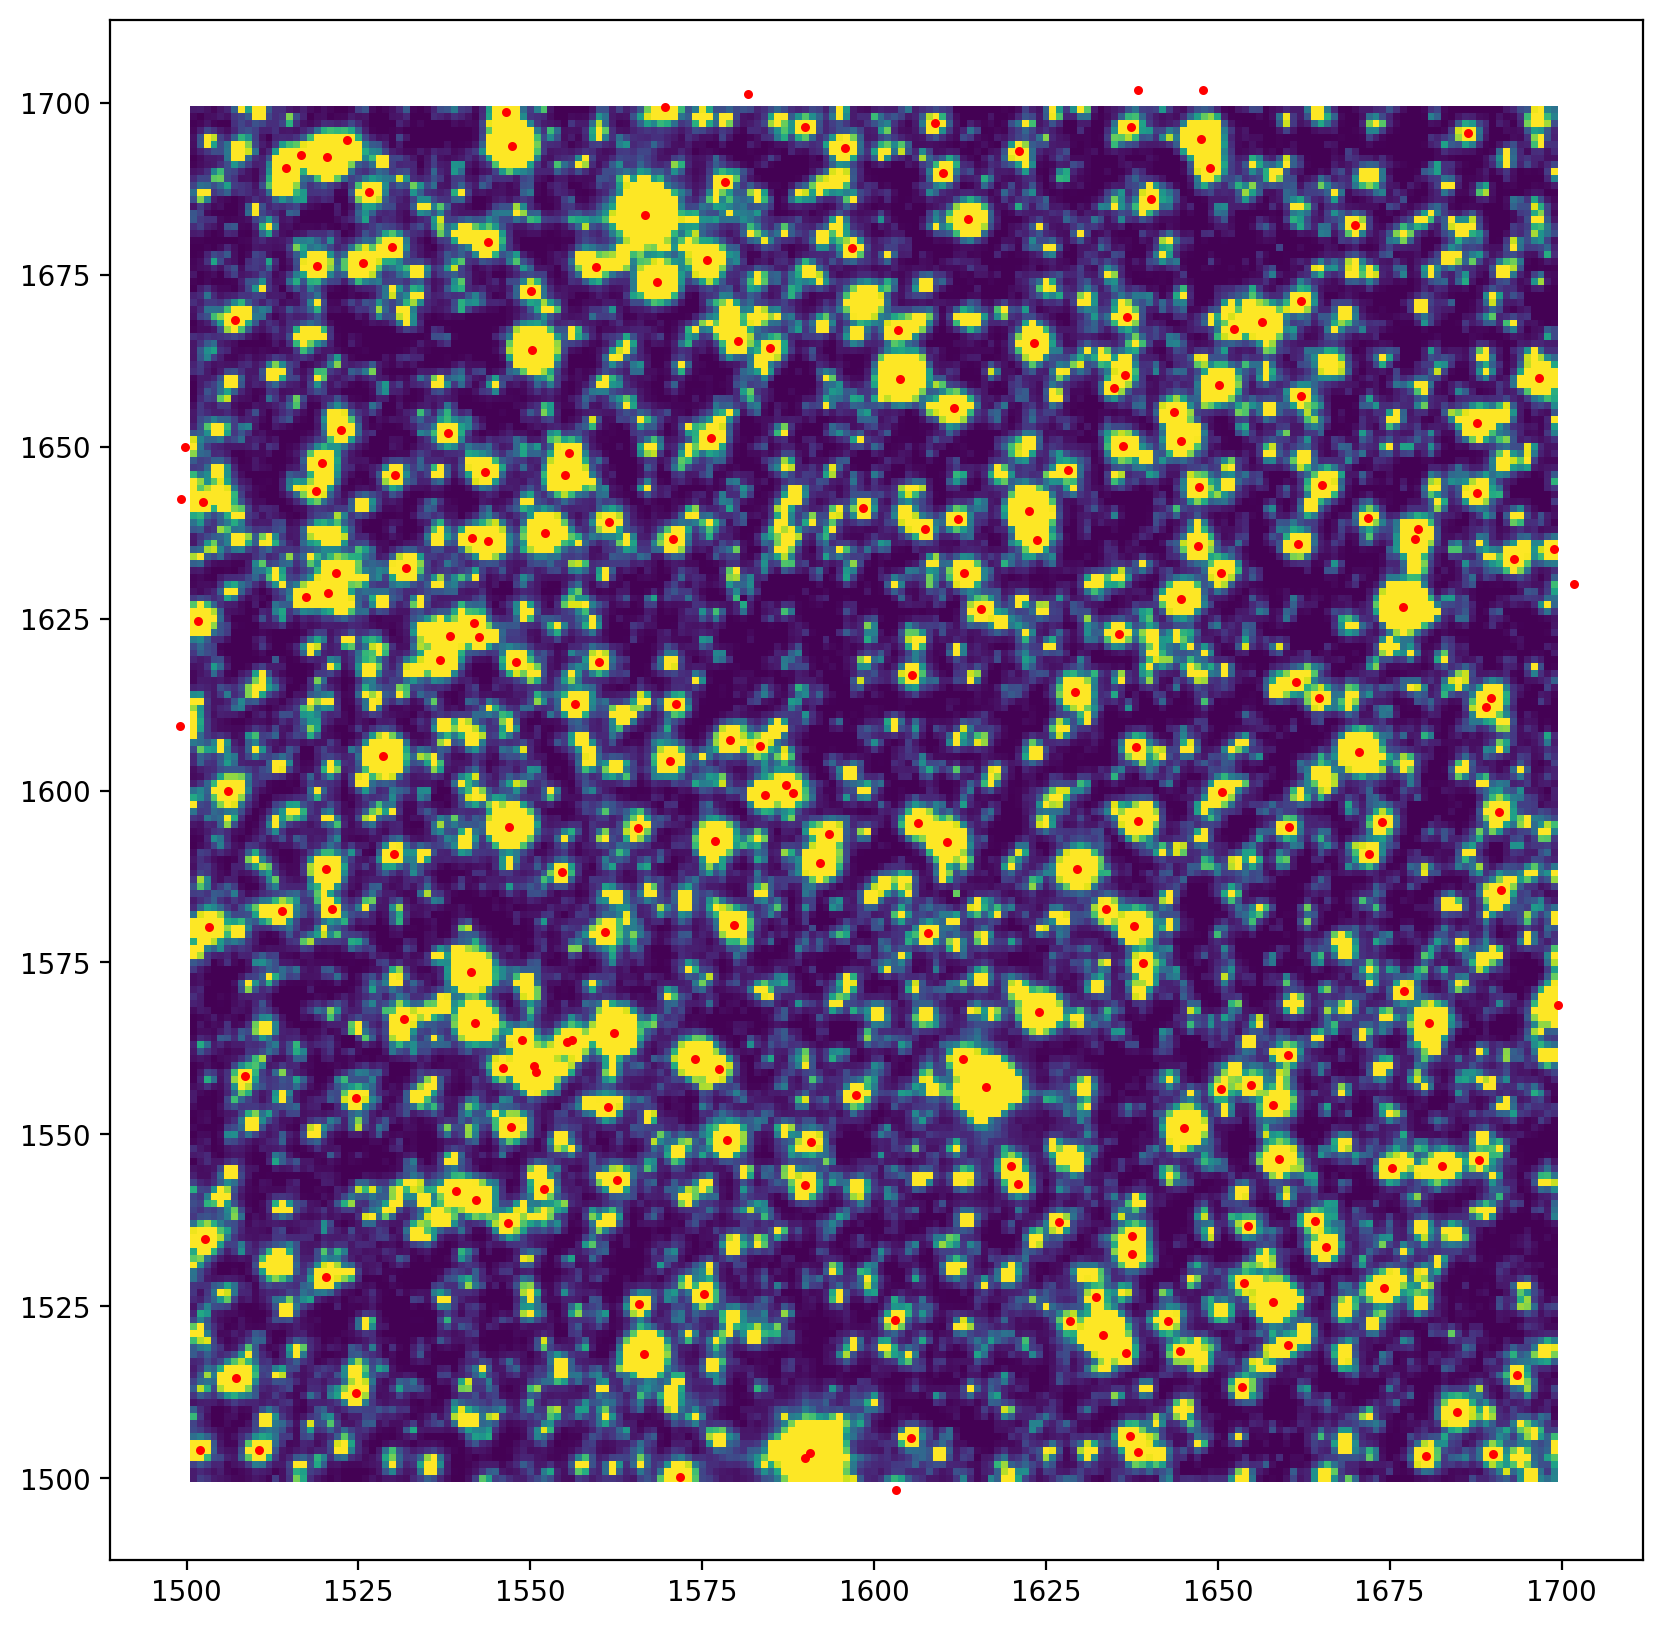

In [15]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data, vmin=0, vmax=100)
k = df.phot_rp_mean_flux > 1e5
plt.scatter(df["X0"][k], df["Y0"][k], s=5, c="r")

plt.gca().set_aspect("equal")

In [16]:
def get_gaussian_psfs(source_flux, std=1.5):
    nstddevs = 5
    gR, gC = np.mgrid[
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std + 1),
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std) + 1,
    ]
    
    gauss = gaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
    
    dG_x, dG_y = dgaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
        
    s = SparseWarp3D(
            gauss * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        )
        
    ds_x = SparseWarp3D(
            dG_x * gauss * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    
    ds_y = SparseWarp3D(
            dG_y *  gauss * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    components = [s, ds_x, ds_y]
    return sparse.hstack(components, 'csr')

In [17]:
def get_polar_psfs(source_mask=None):
    if source_mask is None:
        source_mask = np.ones(len(df), bool)
    npixel_radii = 8
    gR, gC = np.mgrid[-npixel_radii:npixel_radii+1, -npixel_radii:npixel_radii+1].astype(float)
    dR = gR[None, :, :] - np.asarray(df['X0'][source_mask] % 1)[:, None, None]
    dC = gC[None, :, :] - np.asarray(df['Y0'][source_mask] % 1)[:, None, None]
    
    rad, phi = np.hypot(dR, dC), np.arctan2(dC, dR)
    s0 = SparseWarp3D(
            rad.transpose([1, 2, 0])**(-2),
            gR[:, :, None] + np.asarray(np.floor(df['X0'][source_mask] - R[0, 0])).astype(int),
            gC[:, :, None] + np.asarray(np.floor(df['Y0'][source_mask] - C[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    
    s1 = SparseWarp3D(
            (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None][source_mask]).transpose([1, 2, 0])**(-2),
            gR[:, :, None] + np.asarray(np.floor(df['X0'][source_mask] - R[0, 0])).astype(int),
            gC[:, :, None] + np.asarray(np.floor(df['Y0'][source_mask] - C[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    
    s2 = SparseWarp3D(
            (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None][source_mask]**2).transpose([1, 2, 0])**(-2),
            gR[:, :, None] + np.asarray(np.floor(df['X0'][source_mask] - R[0, 0])).astype(int),
            gC[:, :, None] + np.asarray(np.floor(df['Y0'][source_mask] - C[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    return sparse.csr_matrix(np.asarray([s0, s1, s2, np.ones_like(s0)])[:, :, 0].T)

In [39]:
y = data.ravel()
yerr = err.ravel()
# Finite pixels
k = np.isfinite(y)


source_flux = np.asarray(df.phot_rp_mean_flux)
# Guess standard deviation of 1.5 pixel
s = get_gaussian_psfs(source_flux, 1.)
flux_mask = np.zeros(s.shape[1], bool)
flux_mask[:len(df)] = True


sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))


# Pixel contributed to by a single source
j = np.asarray((s[:, flux_mask].multiply(w[flux_mask]) > 1e-2).sum(axis=1))[:, 0] == 1

normed_y = y/s.dot(np.ones(s.shape[1]))
normed_yerr = yerr/s.dot(np.ones(s.shape[1]))
l = normed_y > 0

y = np.log(normed_y[k&j&l])
yerr = (np.abs((1/y)) * normed_yerr[k&j&l])

#g0 = get_gaussian_psfs(np.ones(len(source_flux)), 1)

# sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
# w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))

In [56]:
print(np.shape(yerr))
print(np.shape(normed_yerr[k&j&l]))
print(np.shape(np.abs((1/y))))


(2135,)
(2135,)
(2135,)


In [40]:
np.shape(sigma_w_inv)

(3145, 3145)

In [41]:
# mask out sources where... flux sums to zero? I think?
source_mask = np.asarray((s.multiply(j[:, None]).sum(axis=0) != 0))[0][flux_mask] != 0

In [42]:
sum(source_mask)

2659

In [43]:
p0 = get_polar_psfs(source_mask=source_mask)
sigma_w_inv = p0[k&j&l].T.dot(p0[k&j&l]/yerr[:, None]**2)
w = np.linalg.solve(sigma_w_inv, p0[k&j&l].T.dot(y/yerr**2))

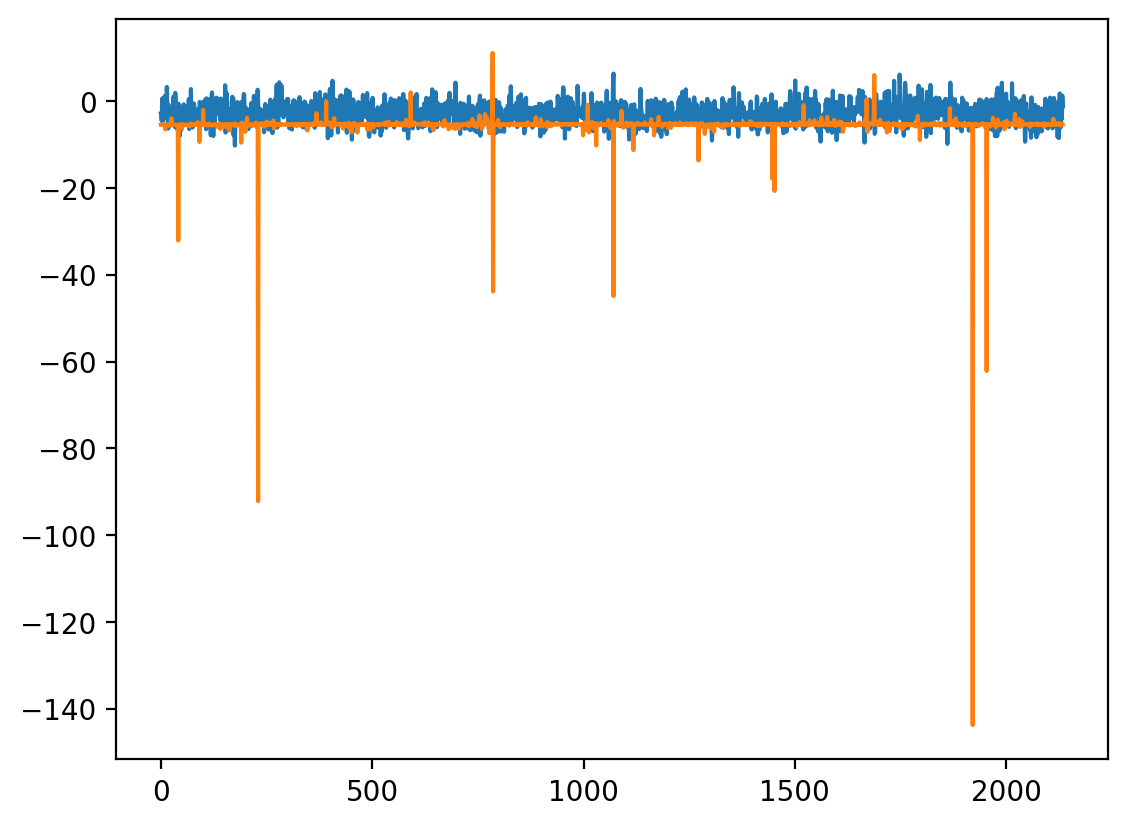

In [44]:
# k checks that the pixel is finite (not nan)
# j checks that it is in the mask for that source
# l checks that the normalized flux > 0
# ...I think
plt.plot(y)
plt.plot(p0[k&j&l].dot(w))  # <- ask Christina about this line

In [59]:
print(np.shape(s[k]))
print(np.shape(yerr))
print(np.shape(normed_yerr))
print(np.shape(y))
# print(np.shape())
# print(np.shape())


(39800, 3145)
(2135,)
(39800,)
(2135,)


In [45]:
# throws an error!
# the problem is that y and yerr is too short, probably because it is defined above as
# yerr = (np.abs((1/y)) * normed_yerr[k&j&l])
# need to either do s[k&j&l] or redefine y and yerr to be just [k]
# not sure which is the right way to go

sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2135 but corresponding boolean dimension is 39800

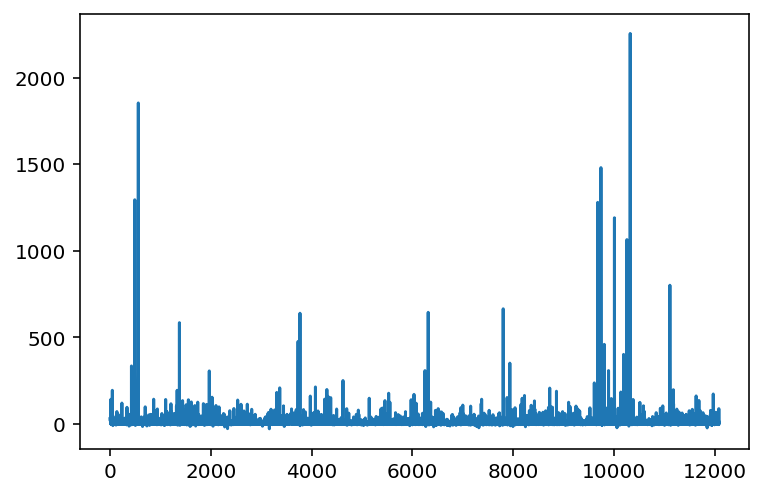

In [145]:
plt.plot(y[k]/s.dot(np.ones(s.shape[1]))[k])

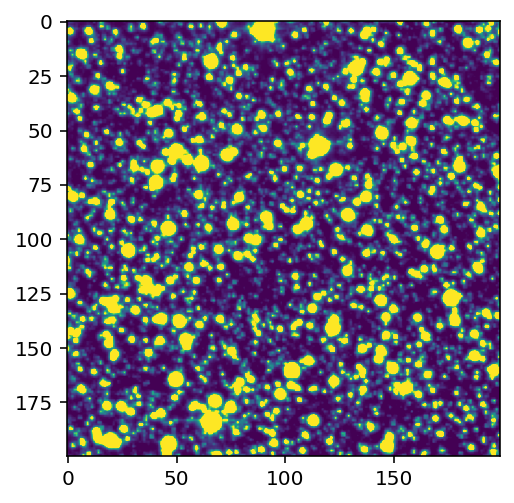

In [79]:
plt.imshow(data, vmin=0, vmax=100)

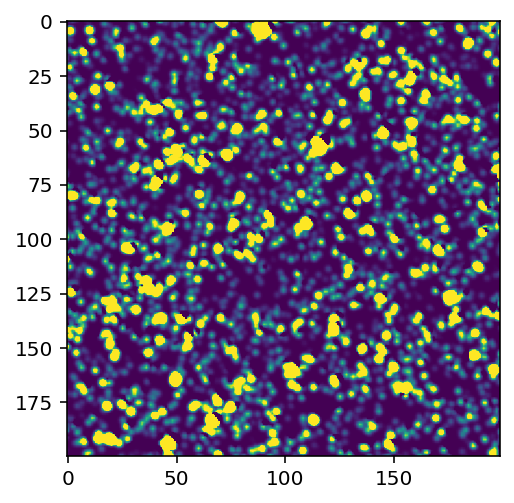

In [84]:
plt.imshow(s.dot(w).reshape(image_shape), vmin=0, vmax=100)

In [11]:
# def get_psfs():
#     npixel_radii = 8
#     gR, gC = np.mgrid[-npixel_radii:npixel_radii+1, -npixel_radii:npixel_radii+1].astype(float)
#     dR = gR[None, :, :] - np.asarray(df['X0'] % 1)[:, None, None]
#     dC = gC[None, :, :] - np.asarray(df['Y0'] % 1)[:, None, None]
    
#     rad, phi = np.hypot(dR, dC), np.arctan2(dC, dR)
# #    rad *= np.asarray(df.phot_rp_mean_flux)[:, None, None]
#     s0 = SparseWarp3D(
#             rad.transpose([1, 2, 0])**(-2),
#             gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
#             gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
#             image_shape,
#         ).sum(axis=1)
    
#     s1 = SparseWarp3D(
#             (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None]).transpose([1, 2, 0])**(-2),
#             gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
#             gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
#             image_shape,
#         ).sum(axis=1)
    
#     s2 = SparseWarp3D(
#             (rad * np.asarray(df.phot_rp_mean_flux)[:, None, None]**2).transpose([1, 2, 0])**(-2),
#             gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
#             gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
#             image_shape,
#         ).sum(axis=1)
#     return sparse.csr_matrix(np.asarray([s0, s1, s2, np.ones_like(s0)])[:, :, 0].T)
#     return sparse.hstack([s0, s1, s2], 'csr')

In [11]:
# how is this differen from earlier get_gaussian_psfs?
# appears to be the same except for the format of the returned line
#     return sparse.csr_matrix(np.asarray([s0, s1, s2, np.ones_like(s0)])[:, :, 0].T)

def get_gaussian_psfs(source_flux, std=1.5):
    nstddevs = 5
    gR, gC = np.mgrid[
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std + 1),
        np.floor(-nstddevs * std) : np.ceil(nstddevs * std) + 1,
    ]
    data = gaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
    s0 = SparseWarp3D(
        data**0 * source_flux,
        gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
        gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
        image_shape,
    ).sum(axis=1)

    s1 = SparseWarp3D(
            data * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)

    s2 = SparseWarp3D(
        data**2 * source_flux,
        gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
        gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
        image_shape,
    ).sum(axis=1)

    dG_x, dG_y = dgaussian_2d(
        gC[:, :, None],
        gR[:, :, None],
        np.asarray(df['X0'] % 1),
        np.asarray(df['Y0'] % 1),
        np.atleast_1d(std),
        np.atleast_1d(std),
    )
        
    ds_x = SparseWarp3D(
            dG_x * data * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)
    ds_y = SparseWarp3D(
            dG_y *  data * source_flux,
            gC[:, :, None] + np.asarray(np.floor(df['Y0'] - C[0, 0])).astype(int),
            gR[:, :, None] + np.asarray(np.floor(df['X0'] - R[0, 0])).astype(int),
            image_shape,
        ).sum(axis=1)

    components = [s1, ds_x, ds_y]
    
    
    return np.asarray(components)[:, :, 0].T
    #return sparse.hstack(components, 'csr')

In [60]:
source_flux = np.asarray(df.phot_rp_mean_flux)
source_flux /= np.median(source_flux)
s = get_gaussian_psfs(source_flux, 1)

y = data.ravel()
yerr = err.ravel()
k = np.isfinite(y)
s = get_gaussian_psfs(source_flux, std=0.6)
sigma_w_inv = s[k].T.dot(s[k]/yerr[k, None]**2)
w = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))

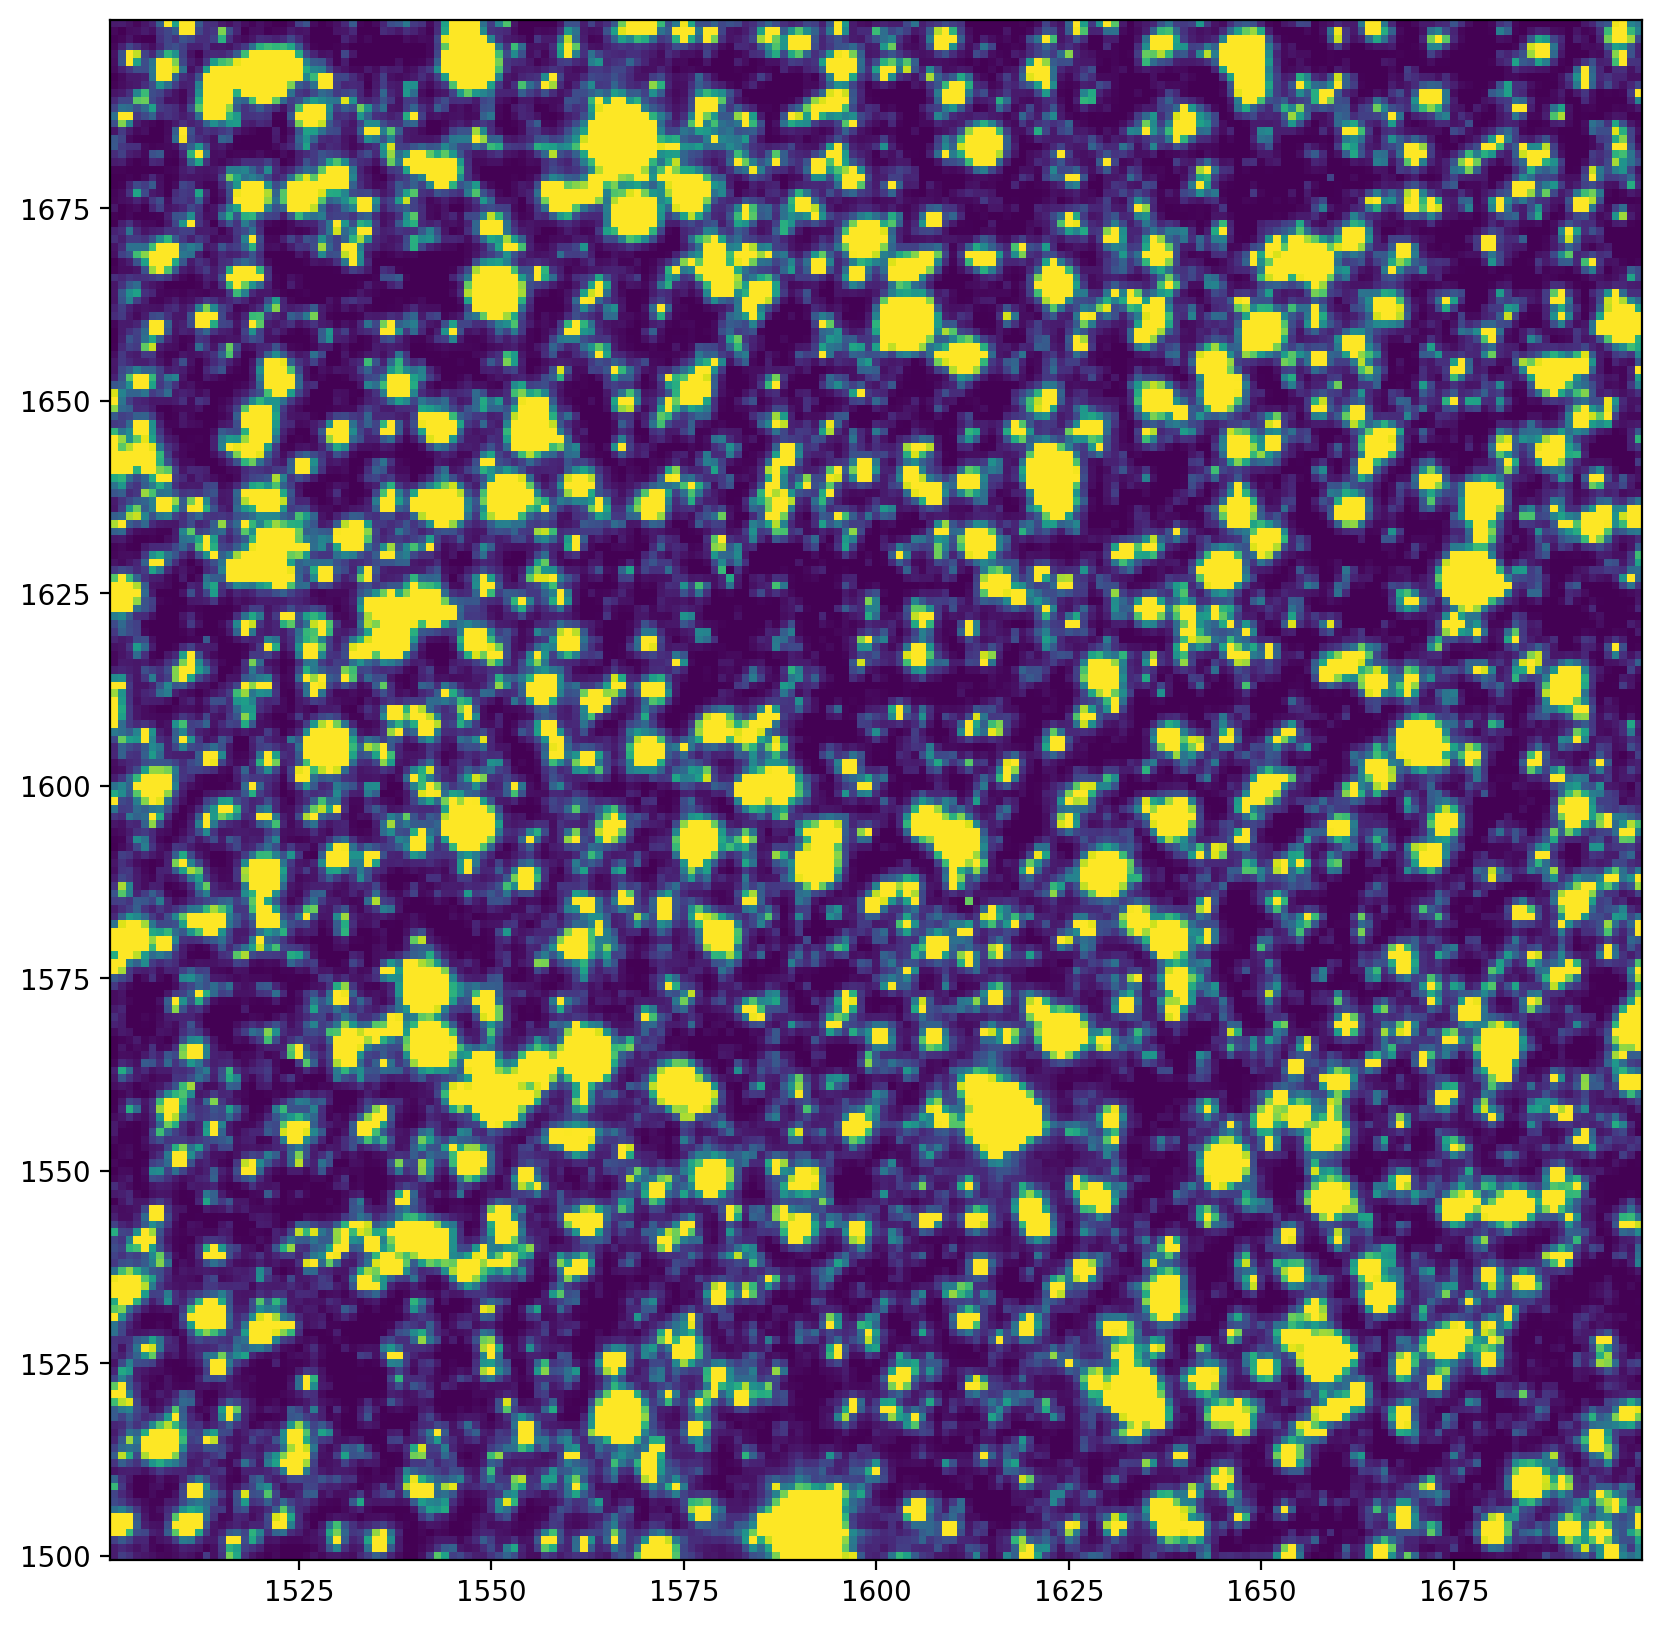

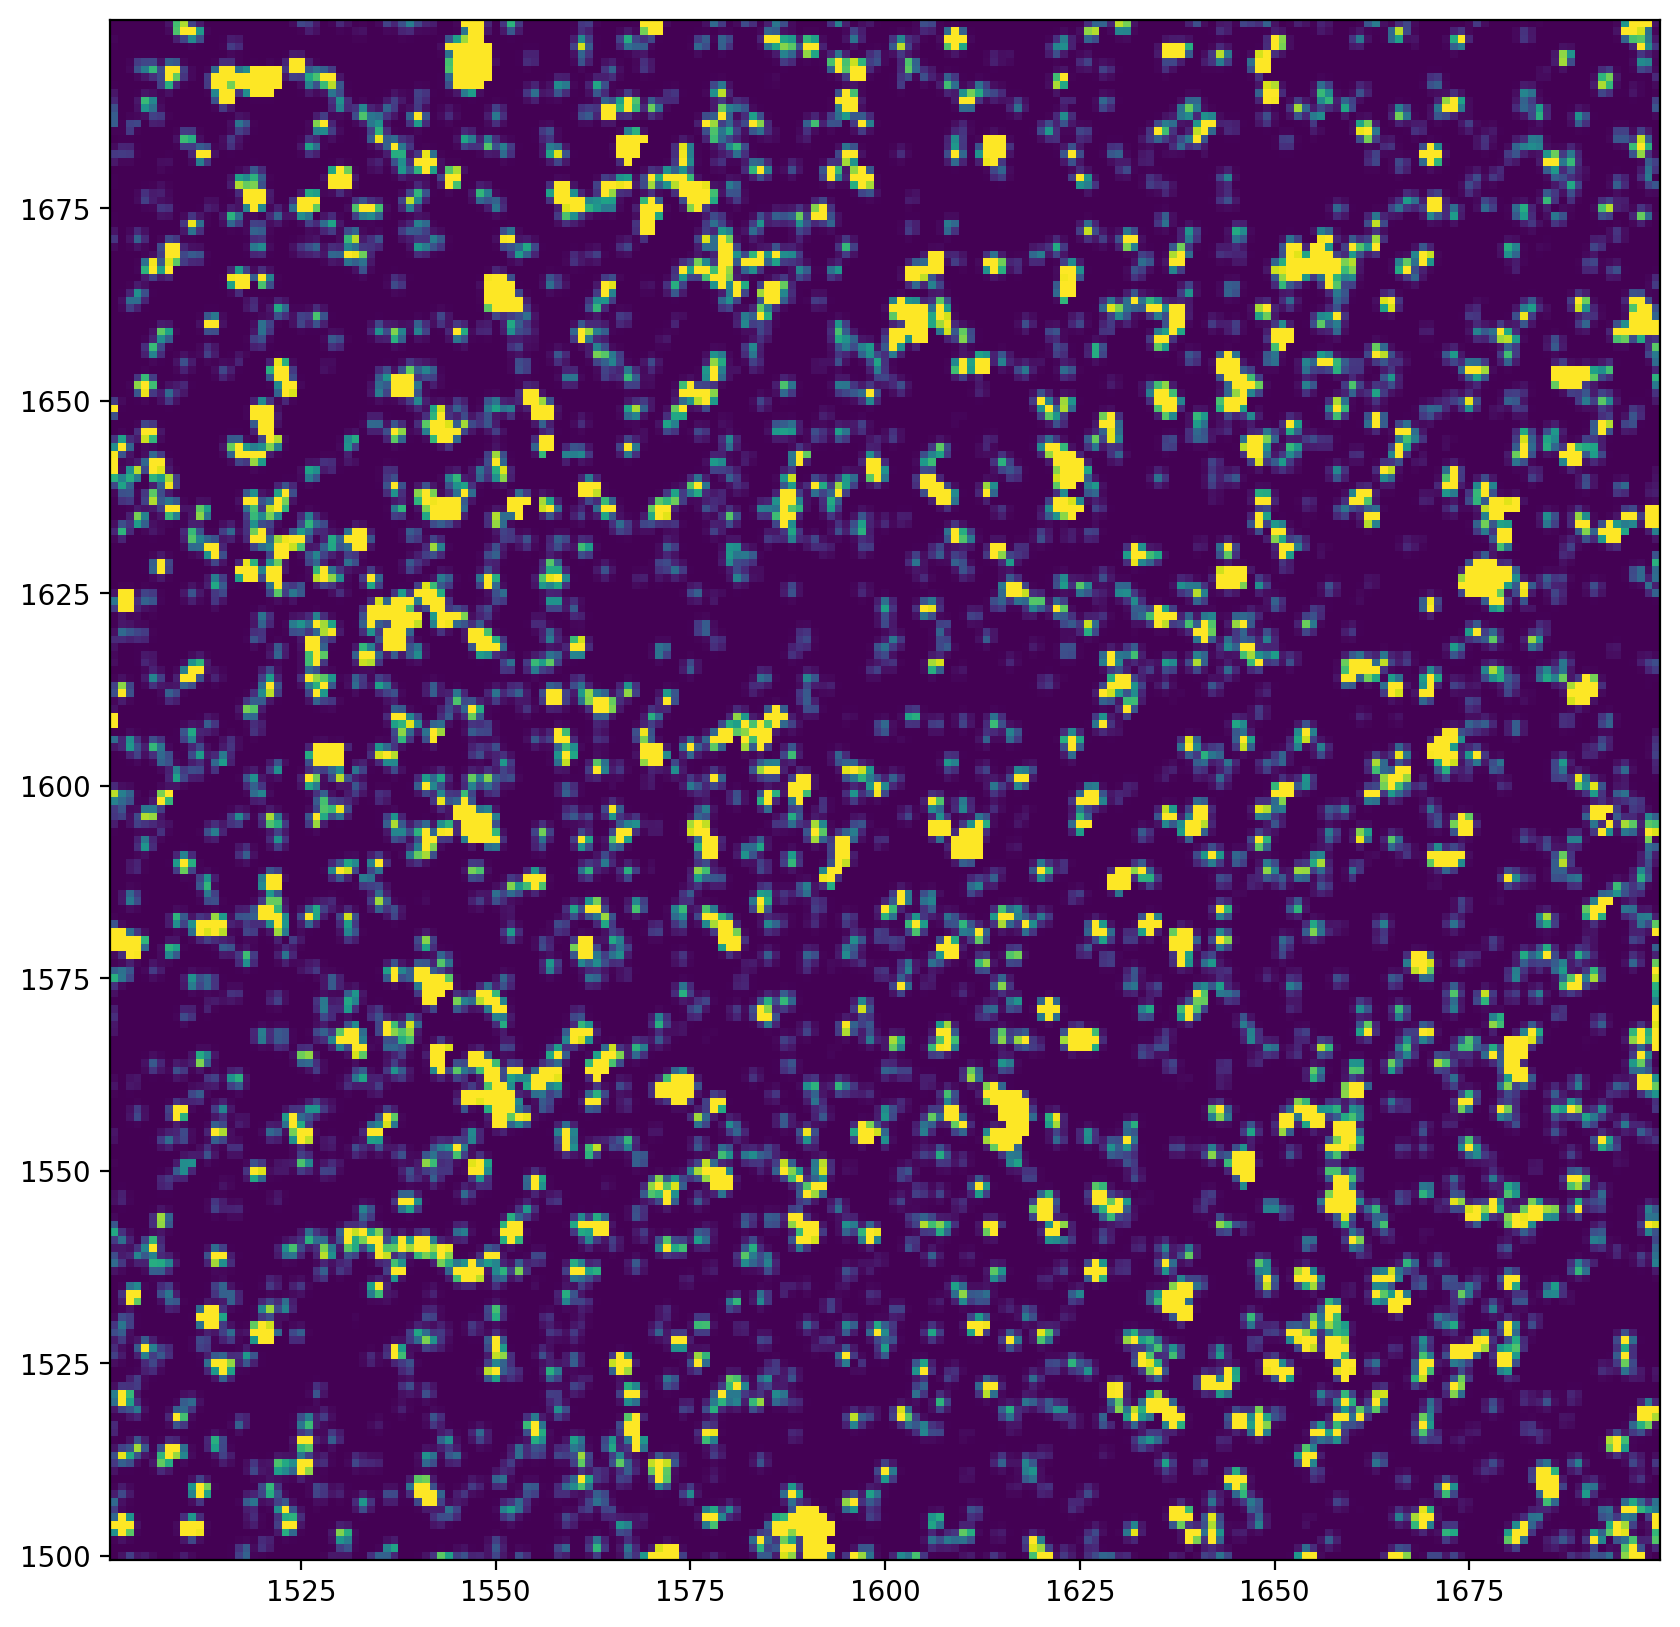

In [61]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data, vmin=0, vmax=100)
plt.gca().set_aspect("equal")

plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, s.dot(w).reshape(image_shape), vmin=0, vmax=100)

In [63]:
# y = np.log(data.ravel())
# yerr = (np.abs((1/y)) * err.ravel())
y = data.ravel()
yerr = err.ravel()

# prior_sigma = np.ones(s.shape[1]) * 1e2
# prior_mu = np.ones(s.shape[1])

k = np.isfinite(y)

# okay, definitely need to talk about this part with Christina!

sigmas = np.linspace(1, 1.5, 30)  # grid of gaussian sigma values to test?
chis = np.zeros_like(sigmas)
for idx, sigma in enumerate(tqdm(sigmas)):
    s = get_gaussian_psfs(sigma)
    sigma_w_inv = s[k].T.dot(s[k].multiply(1/yerr[k, None]**2)).toarray() 
    source_flux = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))
    chis[idx] = np.sum((y[k] - s.dot(source_flux)[k])**2/yerr[k]**2)

s = get_gaussian_psfs(1)
sigma_w_inv = s[k].T.dot(s[k].multiply(1/yerr[k, None]**2)).toarray() 
source_flux = np.linalg.solve(sigma_w_inv, s[k].T.dot(y[k]/yerr[k]**2))
chis[idx] = np.sum((y[k] - s.dot(source_flux)[k])**2/yerr[k]**2)

100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


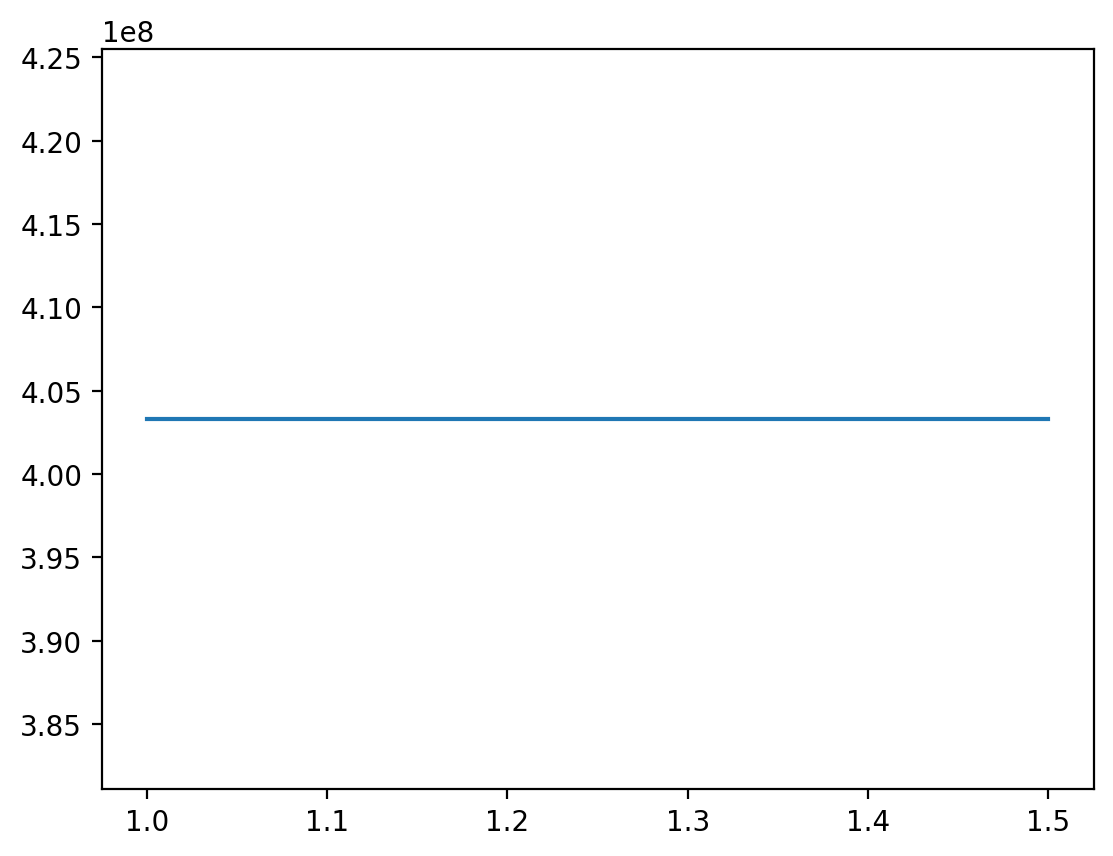

In [72]:
# plt.plot(sigmas, chis)
# hmm... the chis don't seem to have done their fitting properly... not sure what's up with that
# chis

In [395]:
#np.median(source_flux[829*2:829*3])

In [389]:
# plt.plot(source_flux[829:829*2])
# plt.ylim(-1, 1)

In [390]:
# plt.plot(source_flux)

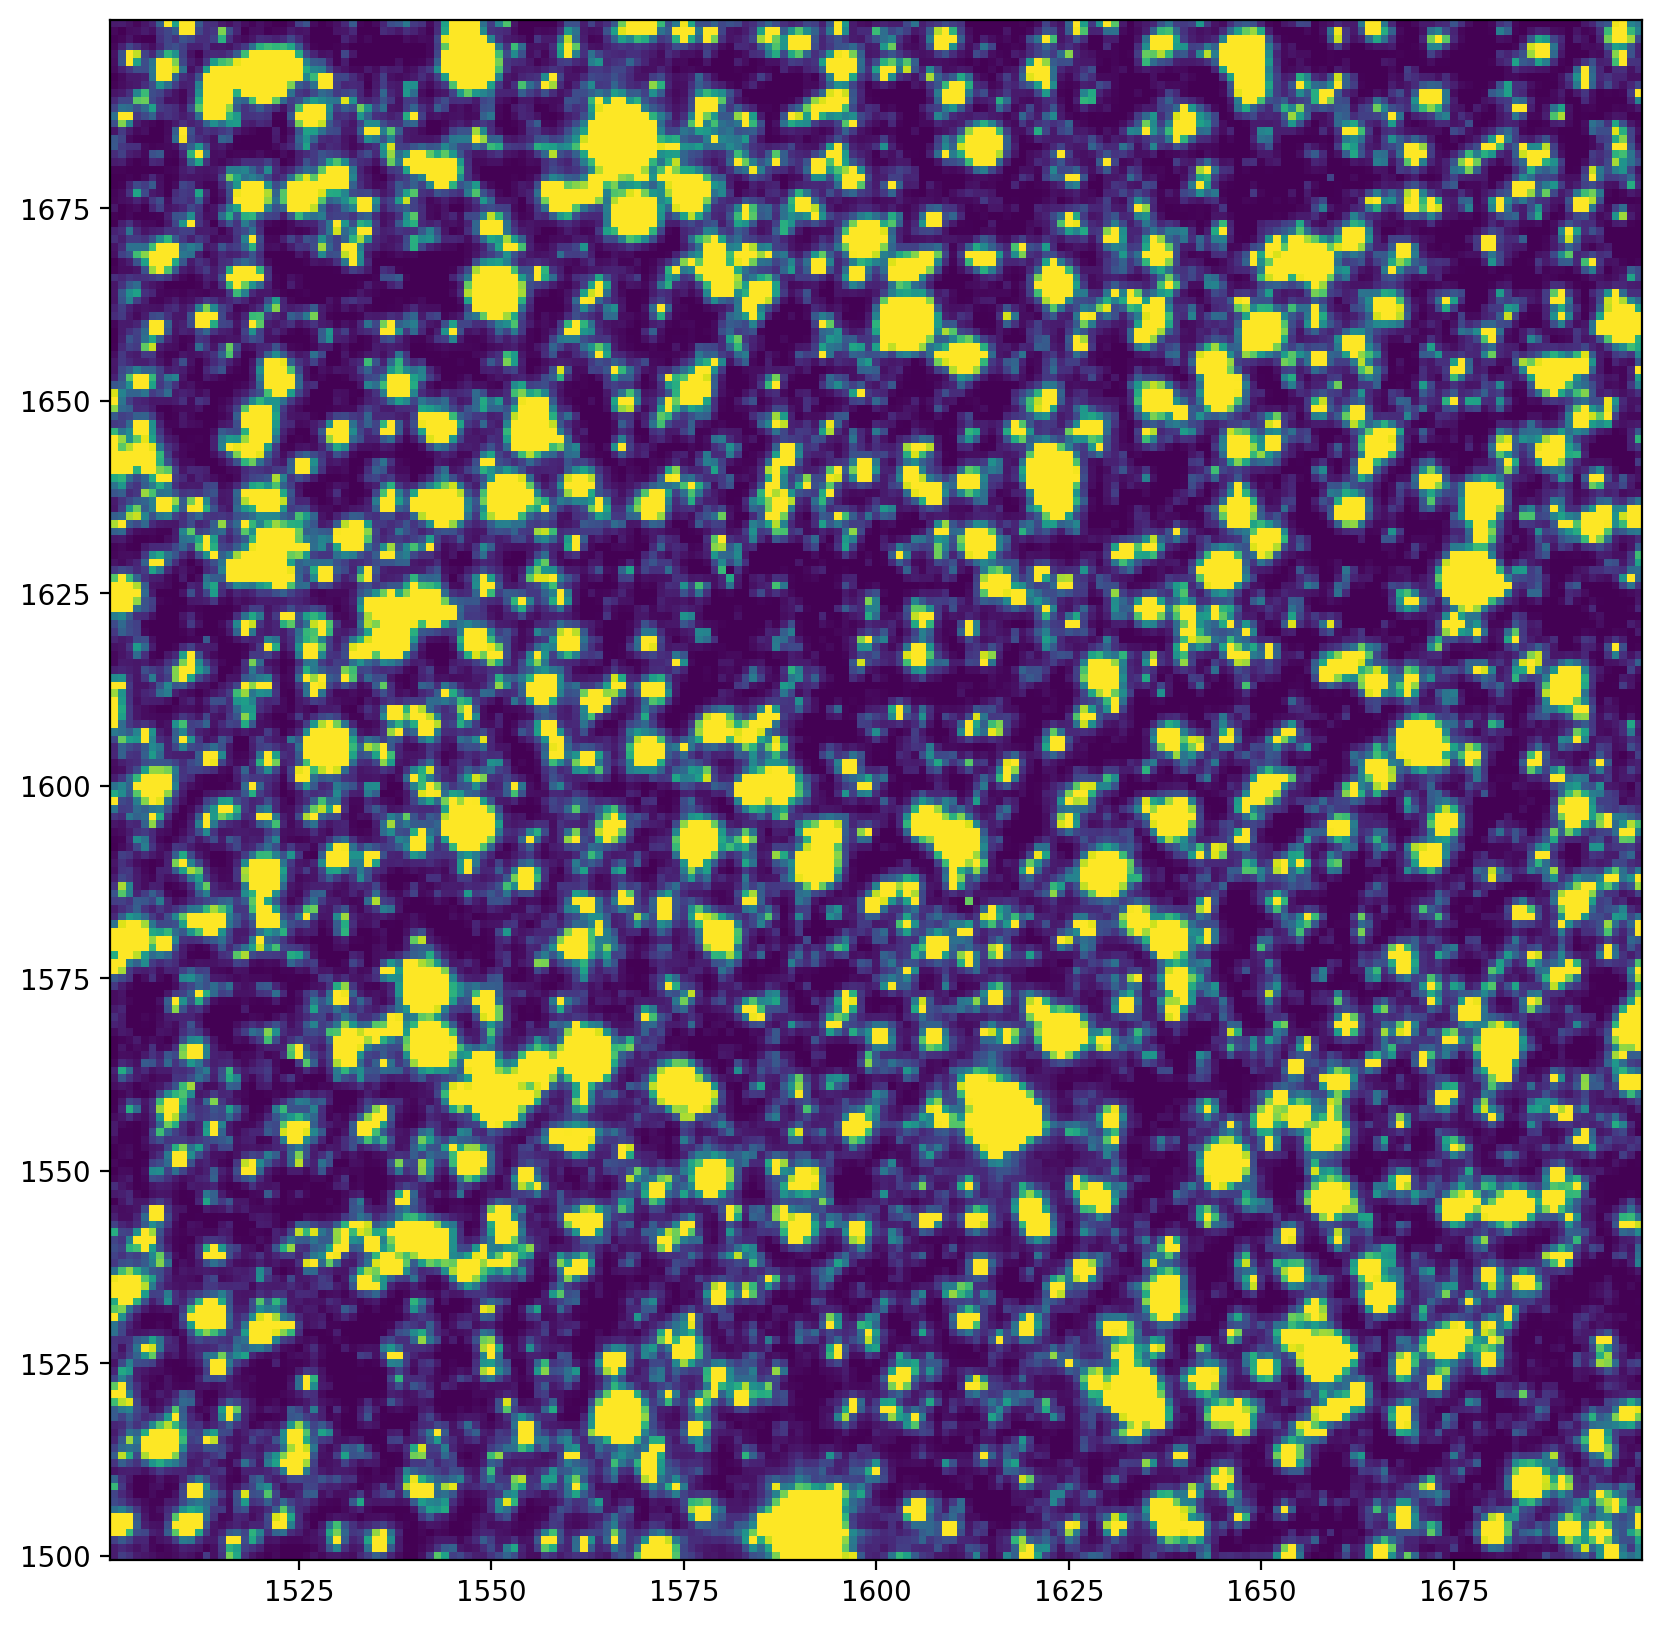

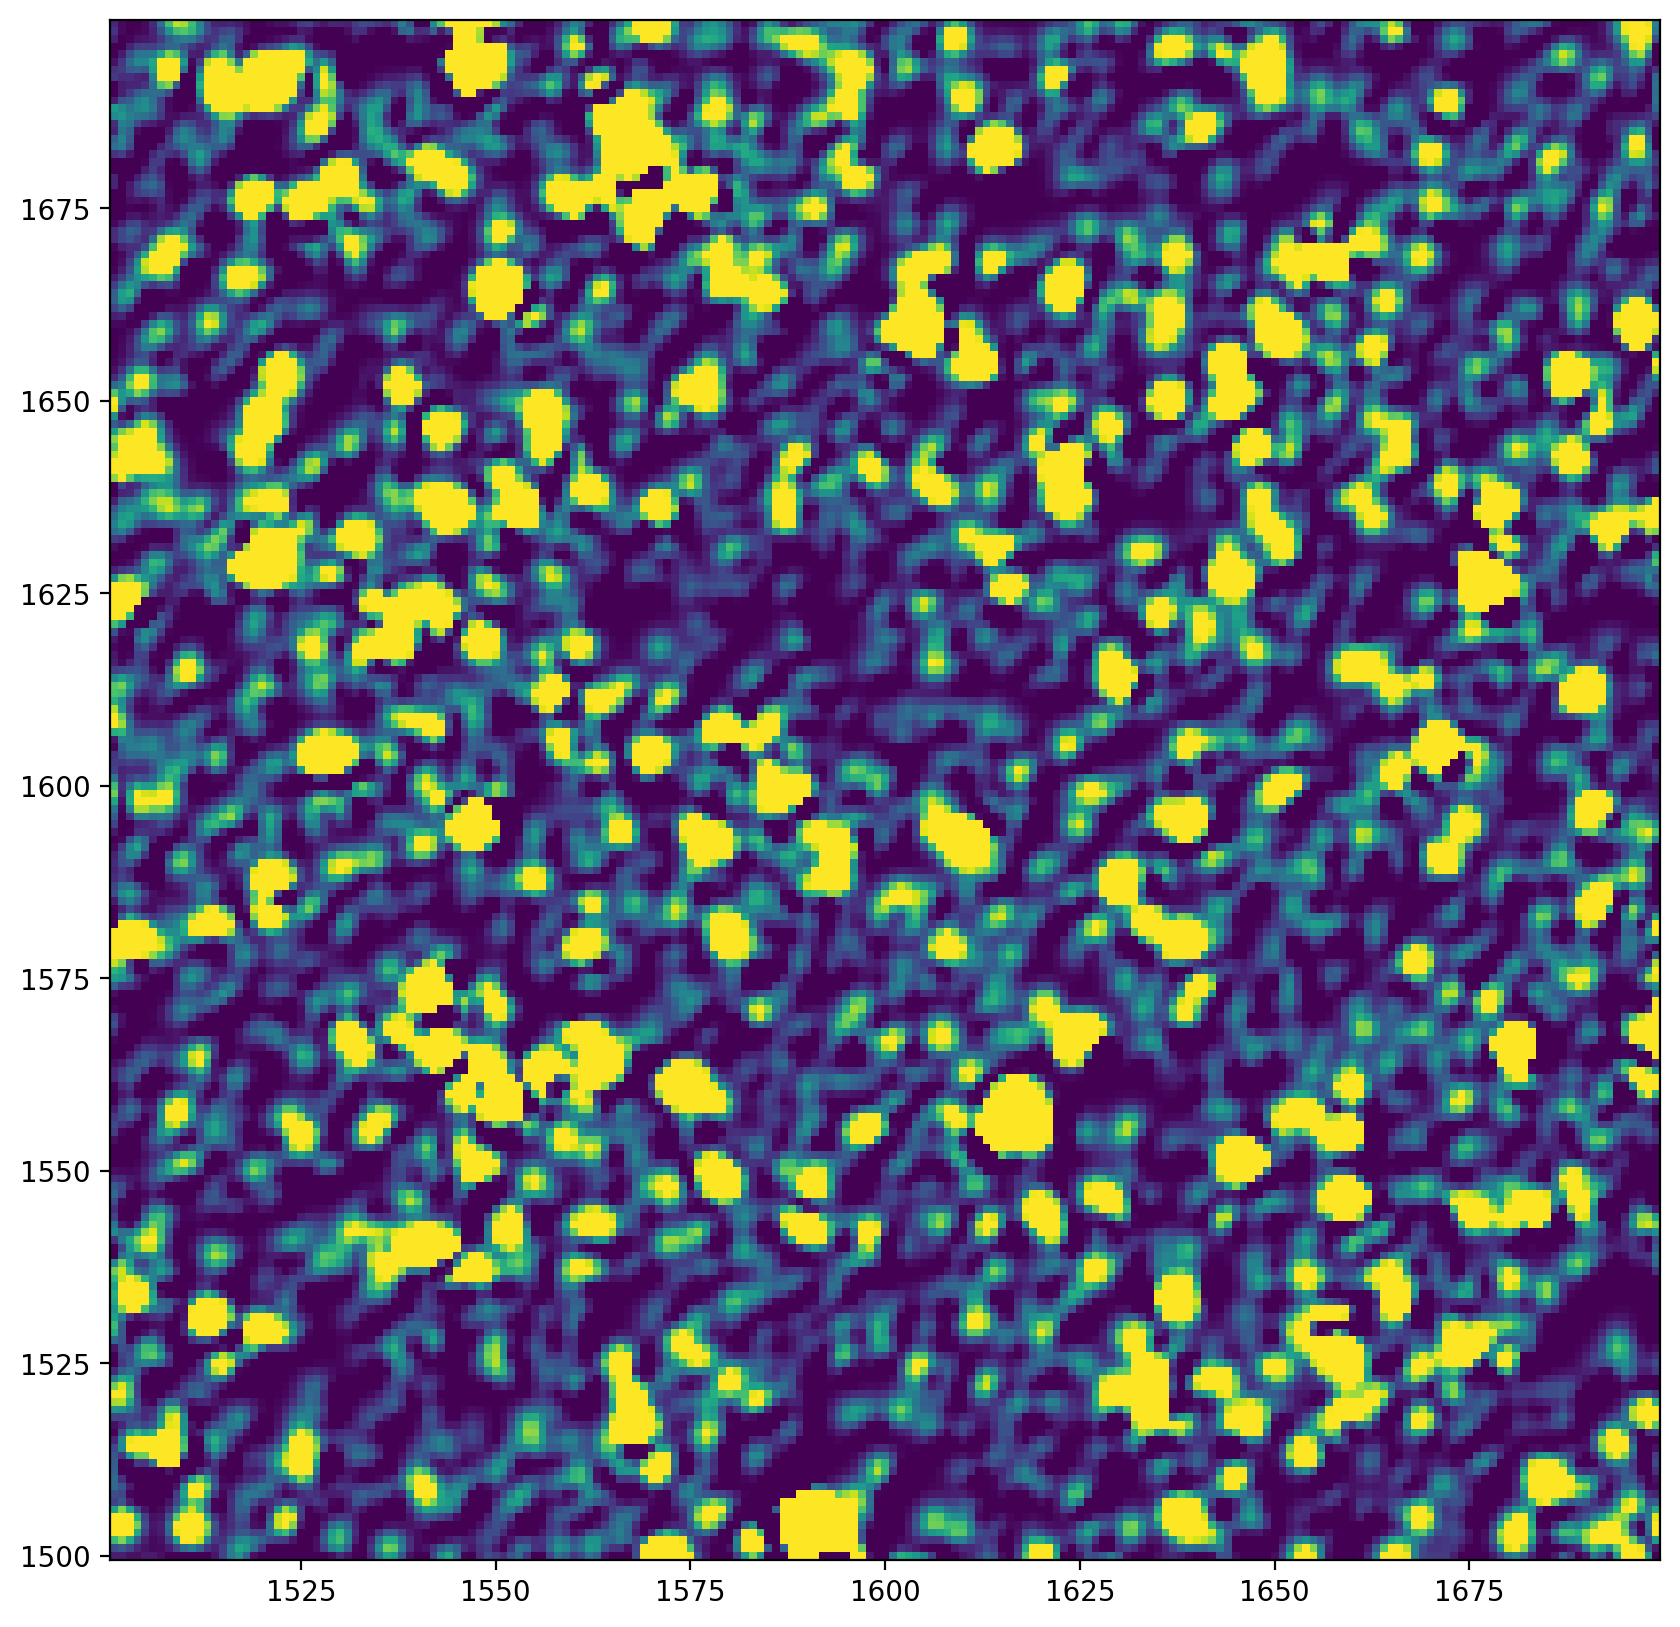

In [66]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data, vmin=0, vmax=100)
plt.gca().set_aspect("equal")

plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, s.dot(source_flux).reshape(image_shape), vmin=0, vmax=100)


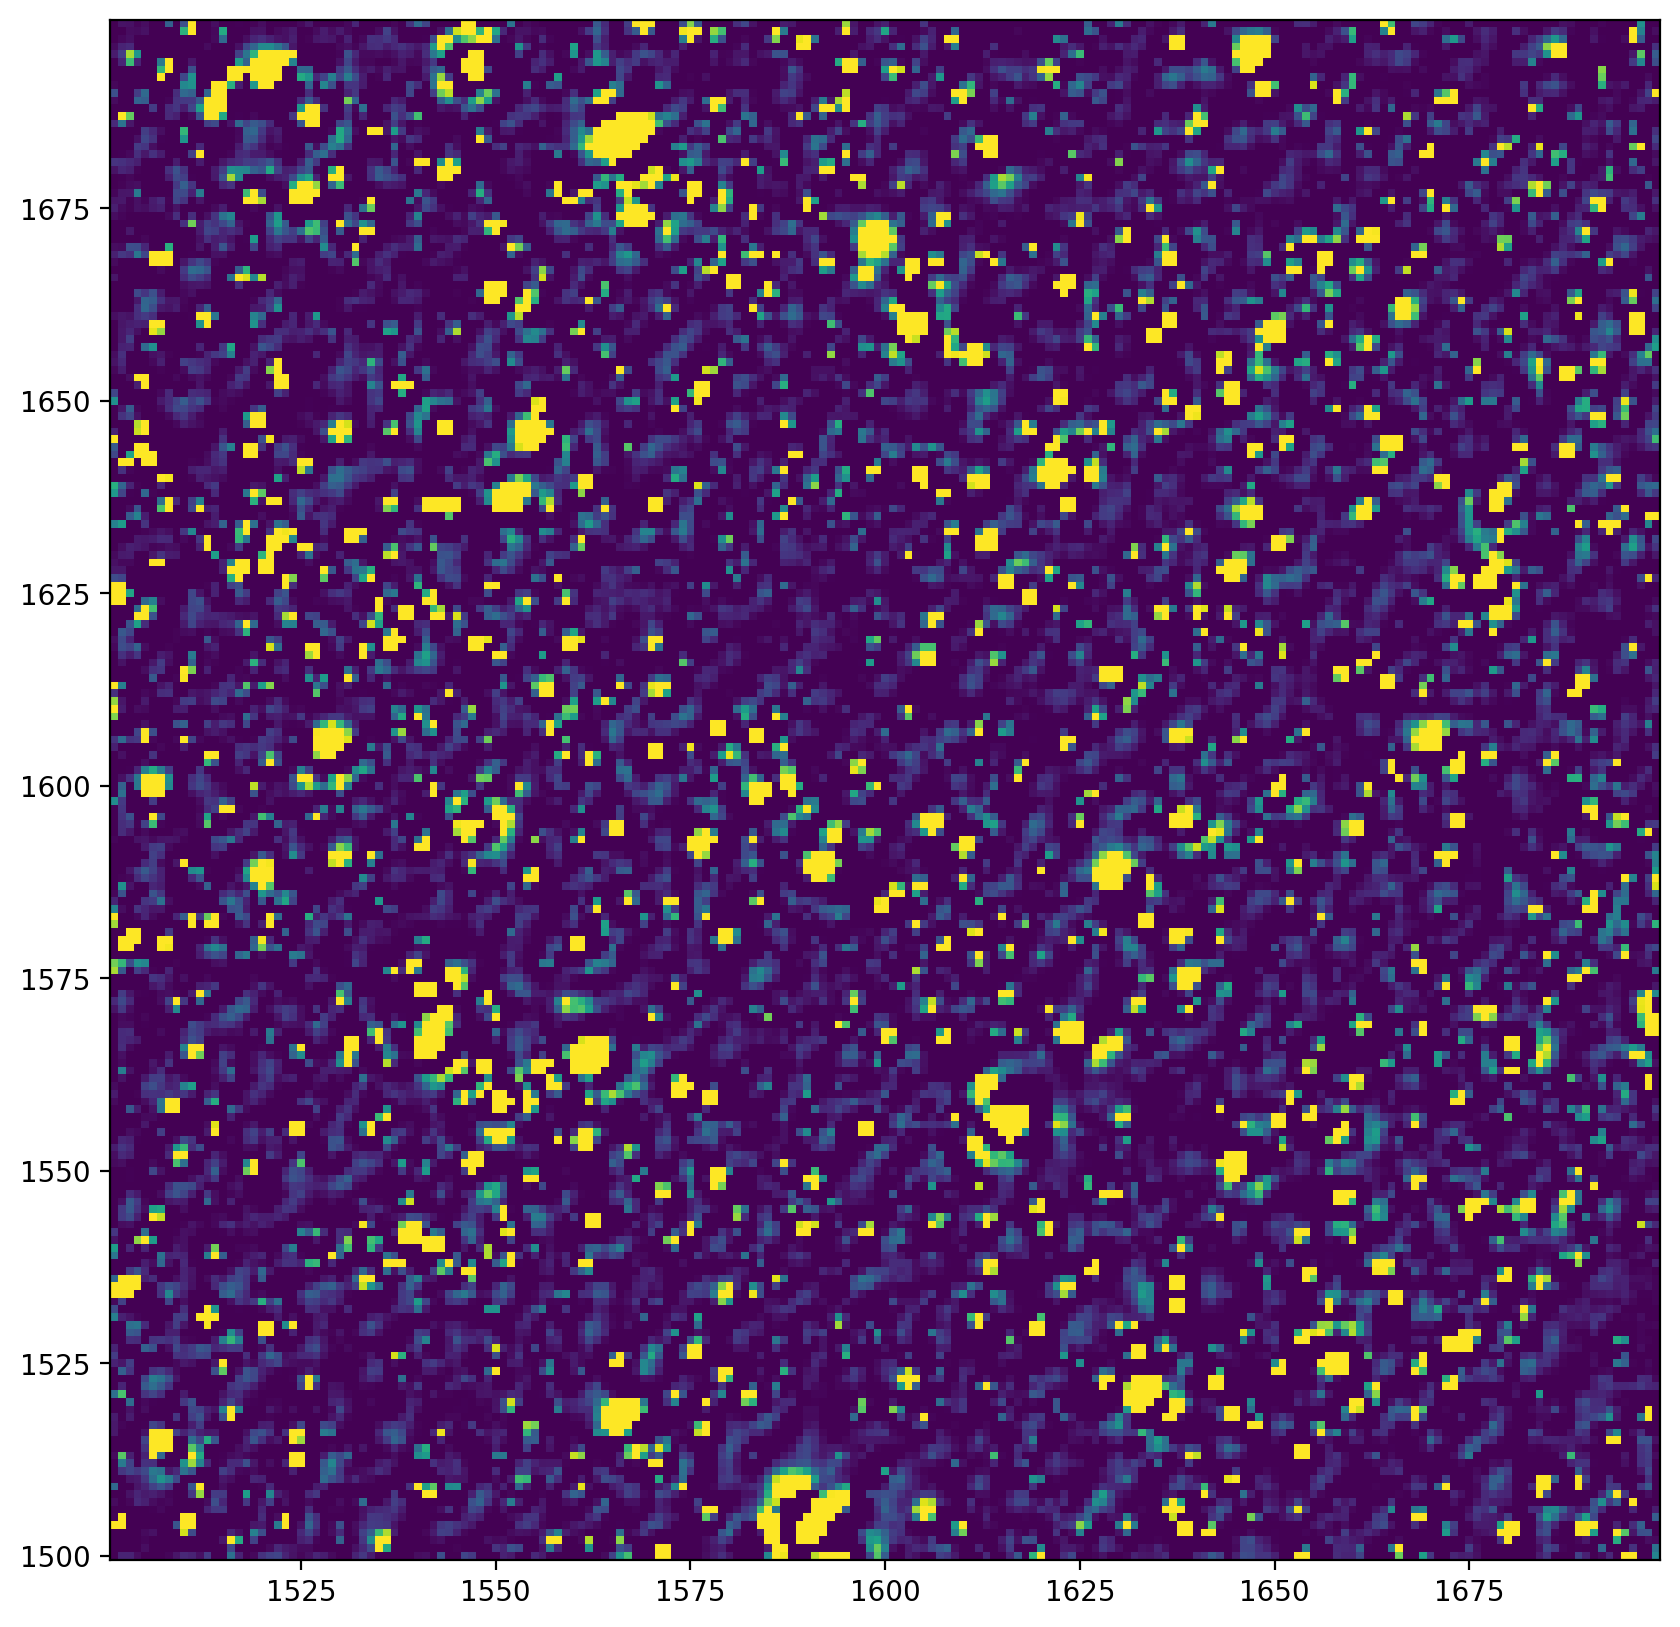

In [70]:
# hmm... this doesn't look like it's working too well
plt.figure(figsize=(10, 10))
plt.pcolormesh(C, R, data - s.dot(source_flux).reshape(image_shape), vmin=0, vmax=100)

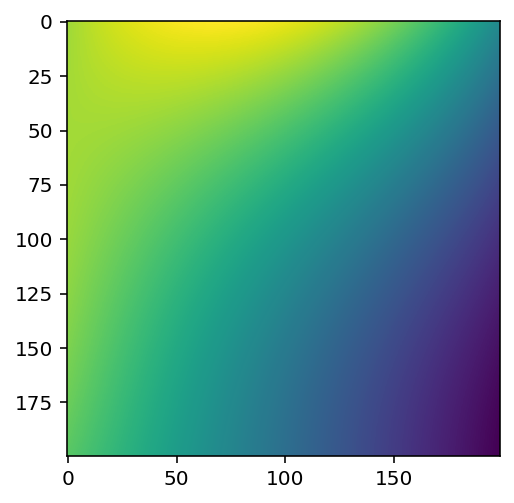

In [334]:
plt.imshow(bkg_model)

/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_19780/3613637149.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg_model), vmin=1, vmax=2)


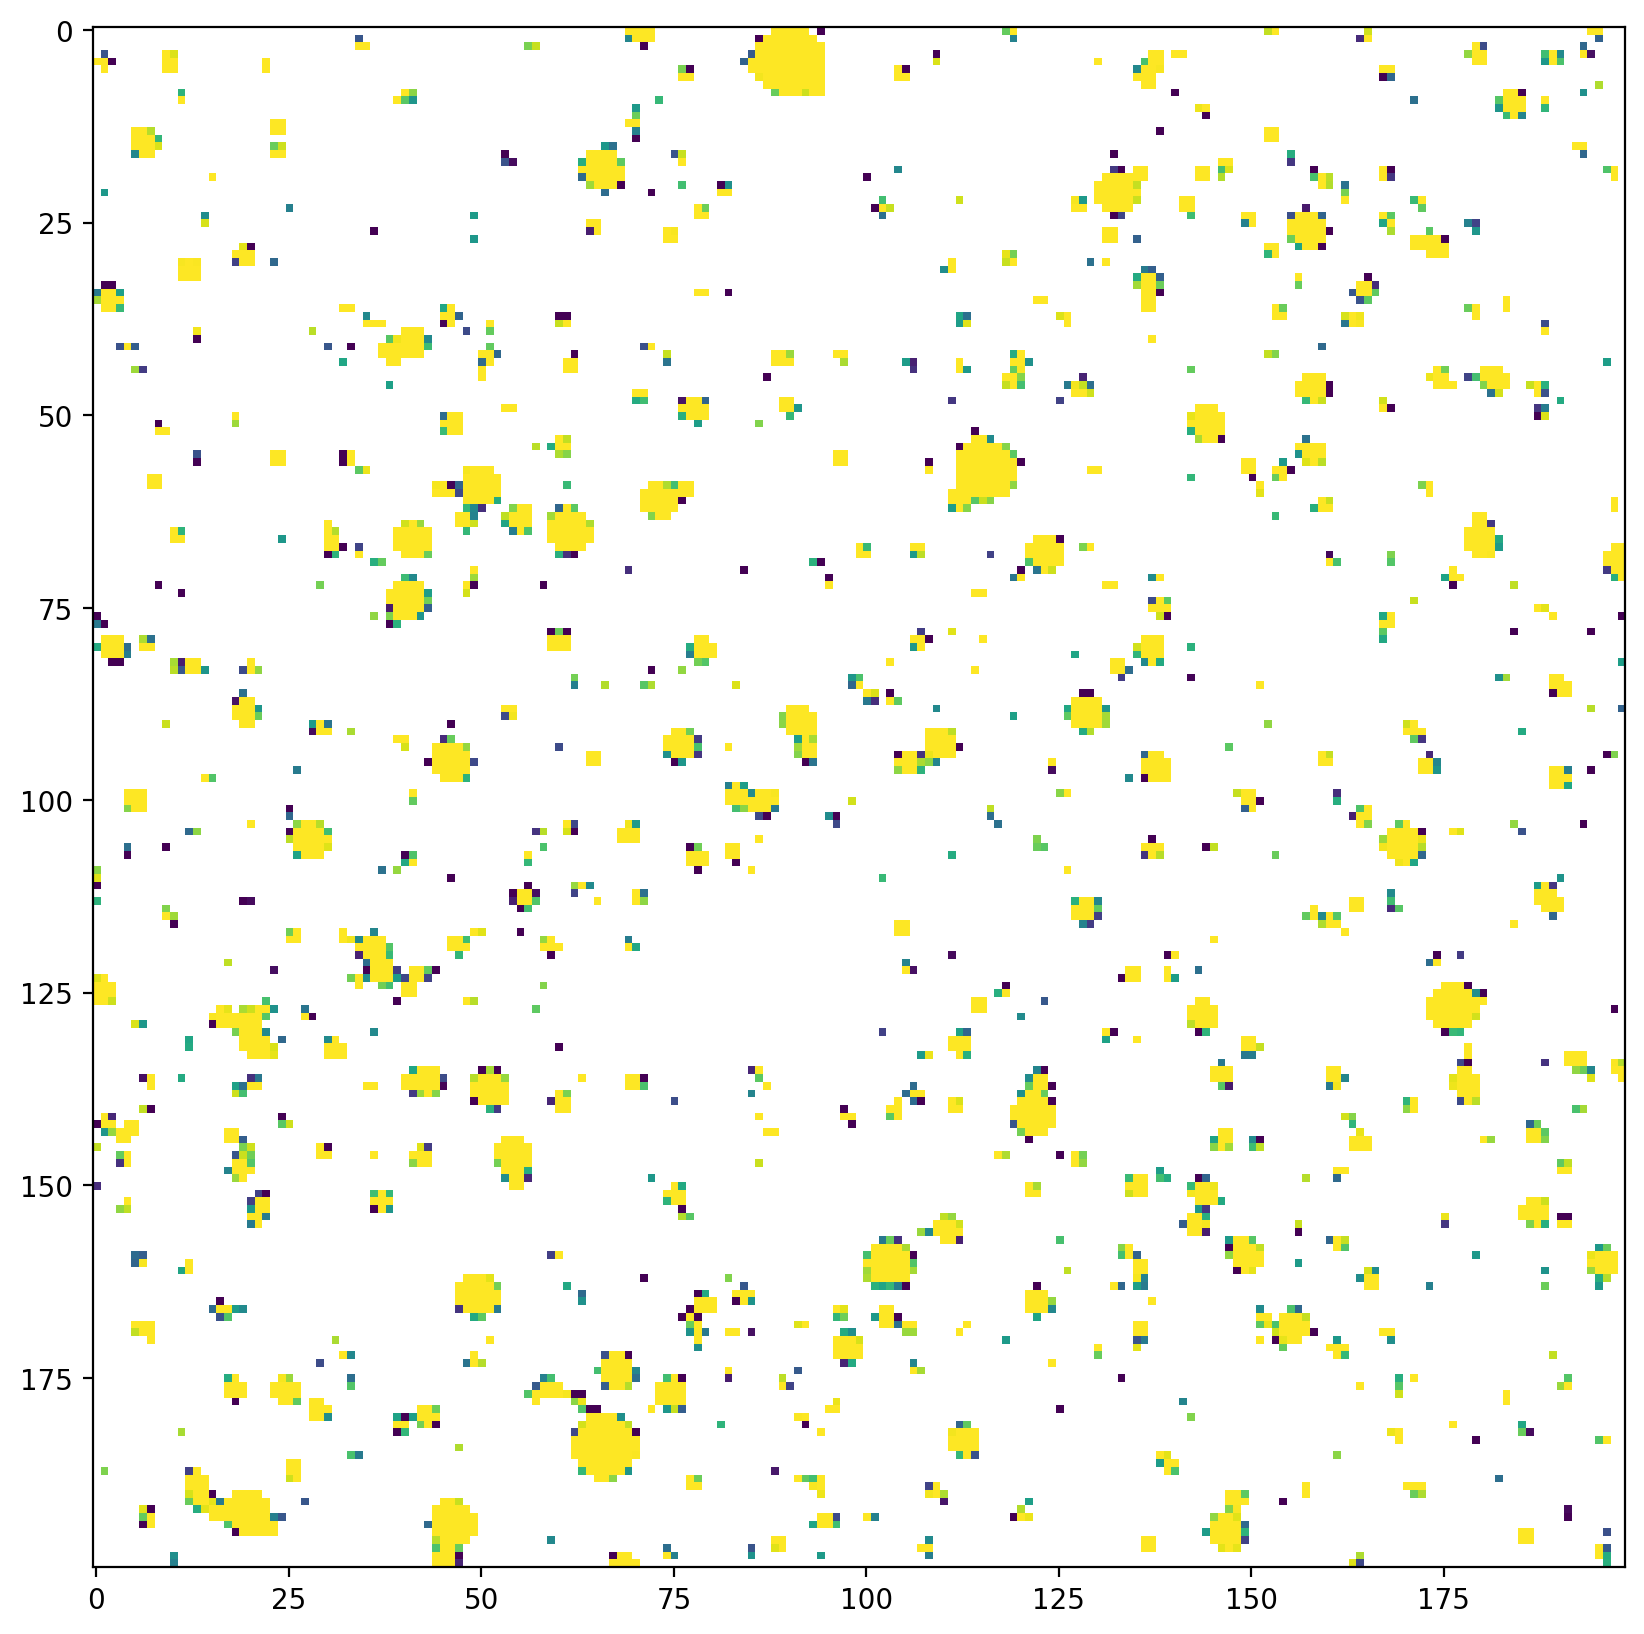

In [71]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log10(data - bkg_model), vmin=1, vmax=2)

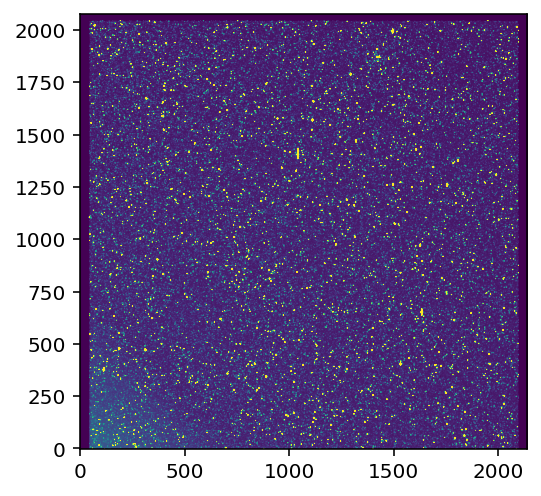

In [181]:
plt.imshow(hdulist[1].data, vmin=100, vmax=1000, origin="lower")